<a href="https://colab.research.google.com/github/AlirezaBeigiMech/Neural-ODE/blob/master/Stochastic_Neural_Operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KDE evaluation time: 1.184606 seconds
FFT + IFFT time:     0.000949 seconds
Reconstruction max abs error: 3.553e-15


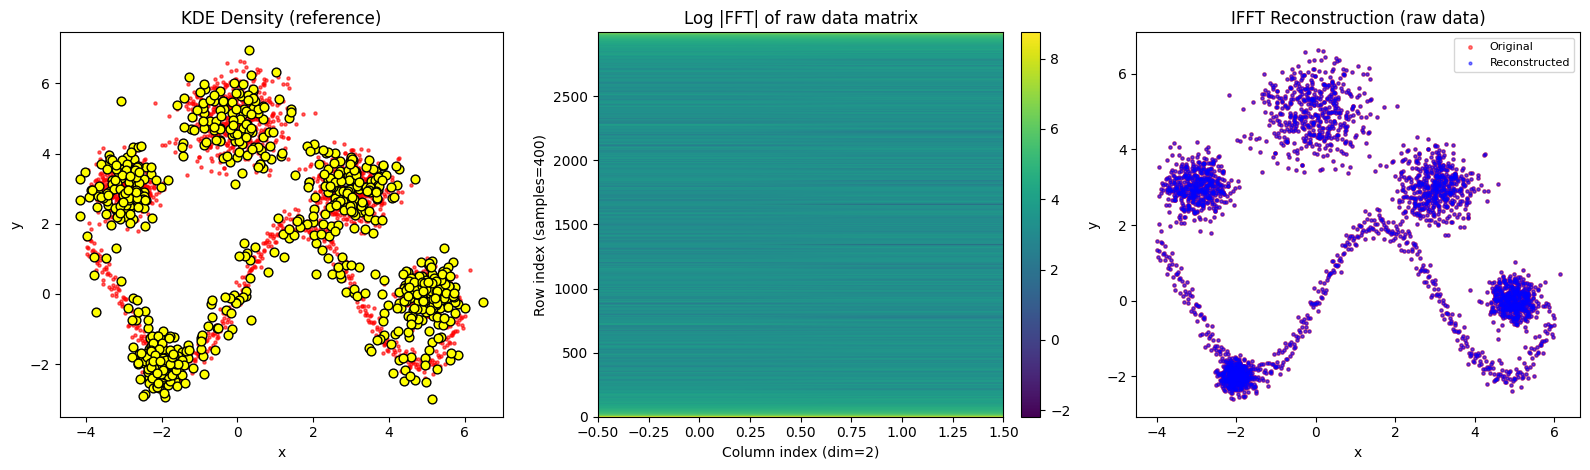

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import time

# ---------- 1) Make the same 2D data ----------
np.random.seed(0)

N = 500
clusters = [
    ([-2, -2], 0.2),
    ([3, 3], 0.5),
    ([0, 5], 0.7),
    ([5, 0], 0.3),
    ([-3, 3], 0.4)
]

data_parts = [np.random.normal(loc=mu, scale=sigma, size=(N, 2)) for mu, sigma in clusters]
data_curve = np.column_stack([
    np.linspace(-4, 6, N),
    np.sin(np.linspace(-4, 6, N)) * 2 + np.random.normal(0, 0.2, N)
])
data = np.vstack(data_parts + [data_curve])

data1 = data  # for FFT comparison

# ---------- 2) Build grid (for KDE visualization only) ----------
x, y = np.meshgrid(np.linspace(-2, 5, 100), np.linspace(-2, 5, 100))
grid_points = np.vstack([x.ravel(), y.ravel()]).T

# ---------- 3) KDE timing (on grid, just for reference) ----------
t0 = time.time()
kde = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(data)
#kde = KernelDensity(kernel="gaussian", bandwidth=0.2, algorithm="kd_tree")
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(x.shape)
samples = kde.sample(n_samples=800, random_state=42)
t1 = time.time()

kde_time = t1 - t0

# (Optional) normalize KDE for display consistency
density /= density.sum()

# ---------- 4) FFT -> IFFT timing on raw data ----------
t2 = time.time()
F = np.fft.fft2(data1)          # FFT of the (400 x 2) matrix
data1_rec = np.fft.ifft2(F)     # IFFT back to time/space domain
t3 = time.time()
fft_time = t3 - t2

# Reconstruction error (take real part; numerical noise may introduce tiny imaginary parts)
recon_error = np.max(np.abs(data1 - data1_rec.real))

# ---------- 5) Report ----------
print(f"KDE evaluation time: {kde_time:.6f} seconds")
print(f"FFT + IFFT time:     {fft_time:.6f} seconds")
print(f"Reconstruction max abs error: {recon_error:.3e}")

# ---------- 6) Visualization ----------
fig, axs = plt.subplots(1, 3, figsize=(16, 4.8))

# (a) KDE density (reference)
axs[0].scatter(data[:, 0], data[:, 1], s=5, c="red", alpha=0.6)
axs[0].scatter(samples[:, 0], samples[:, 1], s=40, c="yellow", edgecolor="black", label="KDE samples")


axs[0].set_title("KDE Density (reference)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# (b) Log |FFT| spectrum of the (400 x 2) array
# Note: This is spectrum of the data matrix (rows vs columns), not of a 2D density grid.
log_mag = np.log(np.abs(F) + 1e-12)
im1 = axs[1].imshow(log_mag, origin="lower", aspect="auto")

axs[1].set_title("Log |FFT| of raw data matrix")
axs[1].set_xlabel("Column index (dim=2)")
axs[1].set_ylabel("Row index (samples=400)")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# (c) Reconstructed points (should overlap originals)
axs[2].scatter(data[:, 0], data[:, 1], s=6, c="red", alpha=0.5, label="Original")
axs[2].scatter(data1_rec.real[:, 0], data1_rec.real[:, 1], s=4, c="blue", alpha=0.5, label="Reconstructed")
axs[2].set_title("IFFT Reconstruction (raw data)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
axs[2].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


In [15]:
print(log_density)

[-30.73060247 -29.61535843 -28.53111944 ... -19.32184736 -20.2129835
 -21.15904646]


In [19]:
!pip install fastkde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.6 MB/s eta 0:00:00


fastKDE evaluation time: 0.032527 seconds
FFT + IFFT time:         0.000394 seconds
Reconstruction error:    1.776e-15


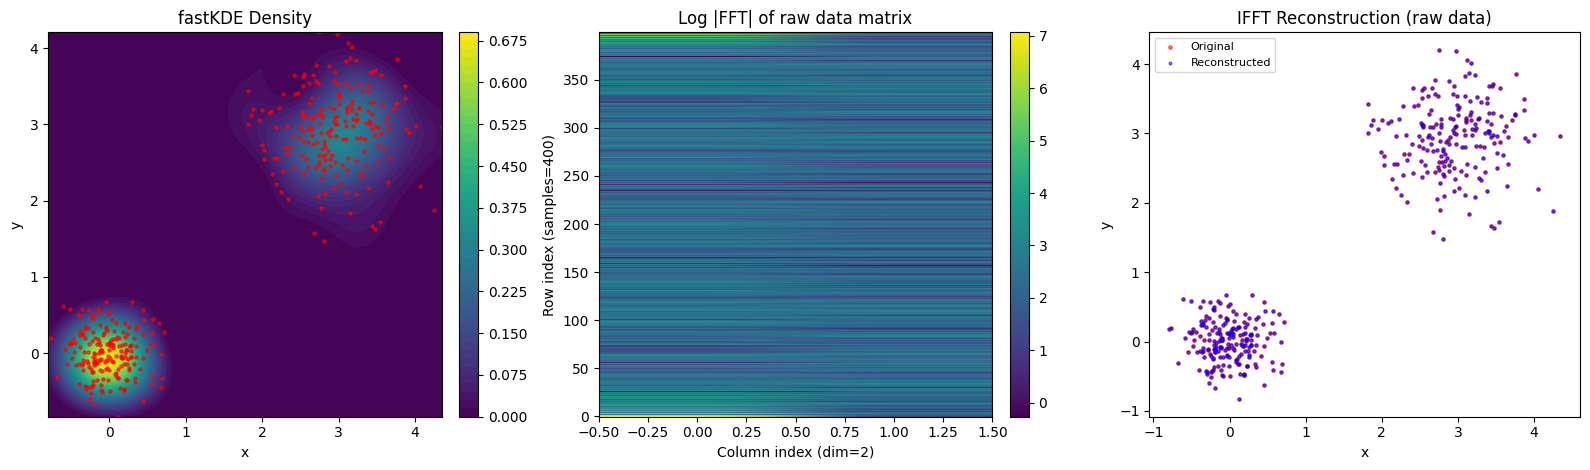

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import fastkde
import time

# ---------- 1) Make the same 2D data ----------
np.random.seed(0)
data = np.concatenate([
    np.random.normal([0, 0], 0.3, size=(200, 2)),
    np.random.normal([3, 3], 0.5, size=(200, 2))
])

data1 = data  # for FFT

# ---------- 2) fastKDE timing ----------
t0 = time.time()
res = fastkde.pdf(data[:, 0], data[:, 1])   # don't pass axes=...
t1 = time.time()
fastkde_time = t1 - t0

# Normalize return format
if isinstance(res, tuple):
    density, axes = res
    # axes may be [x_axis, y_axis] OR (xmin, xmax, ymin, ymax)
    if len(axes) == 2 and all(hasattr(a, "__len__") for a in axes):
        x_axis, y_axis = axes
    elif len(axes) == 4:
        xmin, xmax, ymin, ymax = axes
        nx, ny = density.shape
        x_axis = np.linspace(xmin, xmax, nx)
        y_axis = np.linspace(ymin, ymax, ny)
    else:
        raise ValueError("Unrecognized axes format from fastkde.pdf")
else:
    density = res
    nx, ny = density.shape
    # Build axes from the data range if not provided
    x_axis = np.linspace(data[:, 0].min(), data[:, 0].max(), nx)
    y_axis = np.linspace(data[:, 1].min(), data[:, 1].max(), ny)

# Build mesh so that shapes match density.shape (indexing='ij' -> (nx, ny))
xgrid, ygrid = np.meshgrid(x_axis, y_axis, indexing="ij")

# ---------- 3) FFT -> IFFT timing on raw (400x2) data ----------
t2 = time.time()
F = np.fft.fft2(data1)        # FFT of (400 x 2) matrix
data1_rec = np.fft.ifft2(F)   # IFFT back
t3 = time.time()
fft_time = t3 - t2

# Reconstruction error
recon_error = np.max(np.abs(data1 - data1_rec.real))

# ---------- 4) Report ----------
print(f"fastKDE evaluation time: {fastkde_time:.6f} seconds")
print(f"FFT + IFFT time:         {fft_time:.6f} seconds")
print(f"Reconstruction error:    {recon_error:.3e}")

# ---------- 5) Visualization ----------
fig, axs = plt.subplots(1, 3, figsize=(16, 4.8))

# (a) fastKDE density
# density has shape (len(x_axis), len(y_axis)) to match xgrid/ygrid (indexing='ij')
im0 = axs[0].contourf(xgrid, ygrid, density, levels=50, cmap="viridis")
axs[0].scatter(data[:, 0], data[:, 1], s=5, c="red", alpha=0.6)
axs[0].set_title("fastKDE Density")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# (b) Log |FFT| spectrum of raw (400x2) data
log_mag = np.log(np.abs(F) + 1e-12)
im1 = axs[1].imshow(log_mag, origin="lower", aspect="auto")
axs[1].set_title("Log |FFT| of raw data matrix")
axs[1].set_xlabel("Column index (dim=2)")
axs[1].set_ylabel("Row index (samples=400)")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# (c) FFT reconstruction scatter
axs[2].scatter(data[:, 0], data[:, 1], s=6, c="red", alpha=0.5, label="Original")
axs[2].scatter(data1_rec.real[:, 0], data1_rec.real[:, 1], s=4, c="blue", alpha=0.5, label="Reconstructed")
axs[2].set_title("IFFT Reconstruction (raw data)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
axs[2].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DifferentiableKDE(nn.Module):
    def __init__(self, data: torch.Tensor, log_h_init: float = -1.0):
        """
        data: (N, d) training samples (kept as buffer; make nn.Parameter if you want to learn centers)
        log_h_init: initial log-bandwidth (scalar)
        """
        super().__init__()
        self.register_buffer("data", data)                 # (N, d)
        self.log_h = nn.Parameter(torch.tensor(log_h_init))# scalar bandwidth (extend to per-dim if needed)

    @staticmethod
    def _log2pi(device):  # tiny helper
        return torch.log(torch.tensor(2.0 * torch.pi, device=device))

    def encode_logpdf(self, x: torch.Tensor) -> torch.Tensor:
        """Log p(x) under Gaussian KDE. x: (B, d) -> (B,)"""
        N, d = self.data.shape
        h = torch.exp(self.log_h)
        diffs = (x[:, None, :] - self.data[None, :, :]) / h     # (B, N, d)
        sq = (diffs * diffs).sum(dim=-1)                        # (B, N)
        logK = -0.5 * sq - 0.5 * d * self._log2pi(x.device)     # (B, N)
        log_p = (-d * self.log_h) - torch.log(torch.tensor(float(N), device=x.device)) \
                + torch.logsumexp(logK, dim=1)                  # (B,)
        return log_p

    def _decode_reparam(self, n_samples: int, tau: float, hard: bool) -> torch.Tensor:
        """
        Differentiable decode:
          - soft/straight-through Gumbel-Softmax over centers (mixture pick)
          - reparameterized Gaussian noise (grad through bandwidth)
        Returns (n_samples, d)
        """
        N, d = self.data.shape
        h = torch.exp(self.log_h)

        # Uniform logits over centers (make learnable if you want non-uniform priors)
        logits = torch.zeros(N, device=self.data.device)
        # (n_samples, N) soft/hard one-hot weights
        weights = F.gumbel_softmax(logits.expand(n_samples, -1), tau=tau, hard=hard)
        centers = weights @ self.data                               # (n_samples, d)

        # Reparameterized Gaussian noise
        noise = torch.randn(n_samples, d, device=self.data.device) * h
        return centers + noise

    def forward(
        self,
        query: torch.Tensor,
        n_samples: int,
        *,
        tau: float = 0.7,
        hard: bool = True,
        return_logp_samples: bool = False
    ):
        """
        Forward = ENCODE then DECODE (differentiable).
        Args:
          query: (B, d) points to score
          n_samples: number of samples to draw
          tau: Gumbel-Softmax temperature (↓ -> more discrete)
          hard: True uses straight-through one-hot for center selection
          return_logp_samples: also return log p(samples) under the same KDE
        Returns:
          log_density: (B,)
          samples: (n_samples, d)
          [optional] logp_samples: (n_samples,)
        """
        log_density = self.encode_logpdf(query)                     # ENCODE

        samples = self._decode_reparam(n_samples, tau=tau, hard=hard)  # DECODE (diff)

        if return_logp_samples:
            return log_density, samples, self.encode_logpdf(samples)
        return log_density, samples


torch.manual_seed(0)
data = torch.cat([
    torch.randn(200, 2) * 0.3 + torch.tensor([0.0, 0.0]),
    torch.randn(200, 2) * 0.5 + torch.tensor([3.0, 3.0])
]).float()

layer = DifferentiableKDE(data, log_h_init=-0.7)

query = torch.tensor([[0.0, 0.0], [3.0, 3.0]]).float()
logp, samples, logp_s = layer(query, n_samples=128, tau=0.7, hard=True, return_logp_samples=True)

loss = -(logp.mean() + 0.1 * logp_s.mean())   # example objective
loss.backward()
